# Transformer emotion recognizer

Note: This notebook is designed to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer and the emotion dataset.

**You can igore the error message like `ERROR: pip's dependency resolver does not currently take into account...`.**

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_ma

Import modules and set random seeds.

In [2]:
import os, random
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, saving, optimizers

random.seed(20230629)
np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [5]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print(f'Vocabulary size: {VOCAB_SIZE}')

Vocabulary size: 30522


Download the emotion dataset and check the maximum text length.

In [6]:
from datasets import load_dataset
emotions = load_dataset('emotion', trust_remote_code=True)
max_textlen = max(
    [len(text.split(' '))
     for text in emotions['train']['text'] + emotions['validation']['text']])
print(f'Maximum text length: {max_textlen}')

Maximum text length: 66


Create the training and test datasets.

In [5]:
MAX_LEN = 128

# Training set
train_set = tokenizer(emotions['train']['text'], max_length=MAX_LEN,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])
train_mask = np.array(train_set['attention_mask'])
train_label = tf.keras.utils.to_categorical(emotions['train']['label'], 6)

# Test set
test_set = tokenizer(emotions['validation']['text'], max_length=MAX_LEN,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])
test_mask = np.array(test_set['attention_mask'])
test_label = tf.keras.utils.to_categorical(emotions['validation']['label'], 6)

emotion_labels = emotions['train'].features['label'].names
emotion_labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

Define the positional embedding layer.

In [6]:
@saving.register_keras_serializable()
class Embeddings(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim, **kwargs):
        super(Embeddings, self).__init__(**kwargs)
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(vocab_size, embed_dim)
        self.pos_emb = layers.Embedding(max_len, embed_dim)
        self.ln = layers.LayerNormalization(epsilon=1e-12)
        self.dropout = layers.Dropout(rate=0.5)

    def call(self, inputs):
        position_ids = tf.range(start=0, limit=self.max_len, delta=1)
        position_embeddings = self.pos_emb(position_ids)
        token_embeddings = self.token_emb(inputs)

        # Add positional embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.ln(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

    def build(self, input_shape):
        pass

    def get_config(self):
        config = super().get_config()
        config.update({
            'max_len': self.max_len,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config

Dfiner the Transformer encoder block.

In [7]:
@saving.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim)
        self.dropout_1 = layers.Dropout(rate=0.1)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation='relu')
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(rate=0.1)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, masks):
        batch_size, seq_len = tf.shape(inputs)[0], tf.shape(inputs)[1]
        attention_mask = tf.reshape(
            tf.tile(masks, [1, seq_len]), [batch_size, seq_len, seq_len])

        # Multi-head attention
        attention_output, attention_scores = self.attn(
            inputs, inputs, inputs, # Inputs for Query, Value, Key
            attention_mask=attention_mask,
            return_attention_scores=True)
        attention_output = self.dropout_1(attention_output)
        attention_output = attention_output + inputs # Skip connection
        attention_output = self.ln_1(attention_output)

        # Feed forward
        ffn_1 = self.ffn_1(attention_output)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        ffn_output = ffn_output + attention_output # Skip connection
        ffn_output = self.ln_2(ffn_output)
        return (ffn_output, attention_scores)

    def build(self, input_shape):
        pass

    def get_config(self):
        config = super().get_config()
        config.update({
            'key_dim': self.key_dim,
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
        })
        return config

Define the text classification model consisted of two Transformer encoder blocks.

In [8]:
EMBEDDING_DIM = 512
N_HEADS = 4
KEY_DIM = EMBEDDING_DIM // N_HEADS
FEED_FORWARD_DIM = 2048

text_inputs = layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
mask_inputs = layers.Input(shape=(None,), dtype=tf.int32, name='input_mask')

x = Embeddings(
    MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM, name='text_embedding')(text_inputs)
x, attention_scores1 = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM,
    name='Transformer1')(x, mask_inputs)
x, attention_scores2 = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM,
    name='Transformer2')(x, mask_inputs)
x = layers.Dense(
    256, activation='relu', name='feedforward')(x[:, 0, :]) # use [CLS] token
x = layers.Dropout(rate=0.6, name='dropout')(x)
output = layers.Dense(
    6, activation='softmax', name='softmax')(x)

# Model for training and prediction
transformer_model = models.Model(
    inputs=[text_inputs, mask_inputs], outputs=output,
    name='Transformer_classifier')

# Model for inference including attention scores
attention_scores_model = models.Model(
    inputs=[text_inputs, mask_inputs],
    outputs=[output, attention_scores1, attention_scores2],
    name='Transformer_attention_scores')

transformer_model.summary()

Model: "Transformer_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding      │ (None, 128, 512)  │ 15,693,824 │ input_ids[0][0]   │
│ (Embeddings)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_mask          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Transformer1        │ [(None, 128,      │  3,152,384 │ text_embedding[0… │
│ (TransformerBlock)  │ 512), (None, 4,   │            │ input_mask[0][0]  │
│                     │ 128, 128)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Transformer2        │ [(None, 128,      │  3,152,384 │ Transformer1[0][… │
│ (TransformerBlock)  │ 512), (None, 4,   │            │ input_mask[0][0]  │
│                     │ 128, 128)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 512)       │          0 │ Transformer2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feedforward (Dense) │ (None, 256)       │    131,328 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ feedforward[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Dense)     │ (None, 6)         │      1,542 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,131,462 (84.42 MB)

 Trainable params: 22,131,462 (84.42 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model using the Adam optimizer, and the categorical crossentroy as a loss function.

In [9]:
transformer_model.compile(optimizer=optimizers.Adam(learning_rate=0.00005),
                          loss='categorical_crossentropy',
                          metrics=['acc'])

Train the model. It achieves around 90% accuracy.

In [10]:
%%time
history = transformer_model.fit(
    [train_text, train_mask], train_label,
    validation_data=([test_text, test_mask], test_label),
    batch_size=32, epochs=10)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 68ms/step - acc: 0.2880 - loss: 1.8123 - val_acc: 0.3520 - val_loss: 1.5797
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 69s 60ms/step - acc: 0.3179 - loss: 1.6227 - val_acc: 0.3520 - val_loss: 1.5750
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - acc: 0.3427 - loss: 1.5449 - val_acc: 0.7210 - val_loss: 0.8416
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - acc: 0.6950 - loss: 0.8508 - val_acc: 0.8815 - val_loss: 0.4085
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - acc: 0.8502 - loss: 0.4819 - val_acc: 0.8910 - val_loss: 0.3202
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - acc: 0.8779 - loss: 0.3722 - val_acc: 0.8910 - val_loss: 0.2868
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - acc: 0.8931 - loss: 0.3153 - val_acc: 0.9030 - val_loss: 0.2839
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - acc: 0.9006 - loss: 0.2883 - val_acc: 0.9035 - val_loss: 0.2638
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 

Plot charts for the accuracy and loss values.

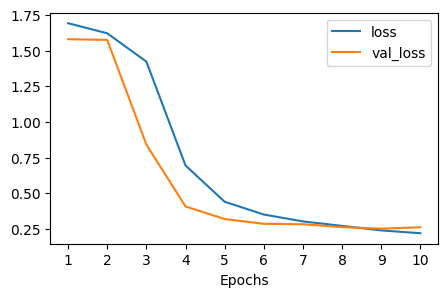

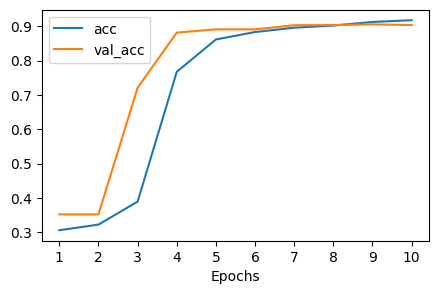

In [11]:
df = DataFrame({'loss': history.history['loss'],
                'val_loss': history.history['val_loss']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'acc': history.history['acc'],
                'val_acc': history.history['val_acc']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

Show the confusion matrix against the test set.

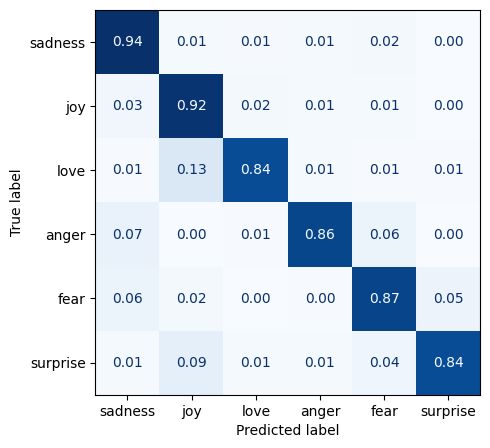

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = transformer_model.predict([test_text, test_mask], verbose=0)

cm = confusion_matrix(
    y_pred = np.argmax(predictions, axis=1),
    y_true = np.argmax(test_label, axis=1),
    normalize='true')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    cm, display_labels=emotions['validation'].features['label'].names)
_ = disp.plot(cmap='Blues', values_format='.2f', colorbar=False, ax=ax)

Show predictions for some sample texts.

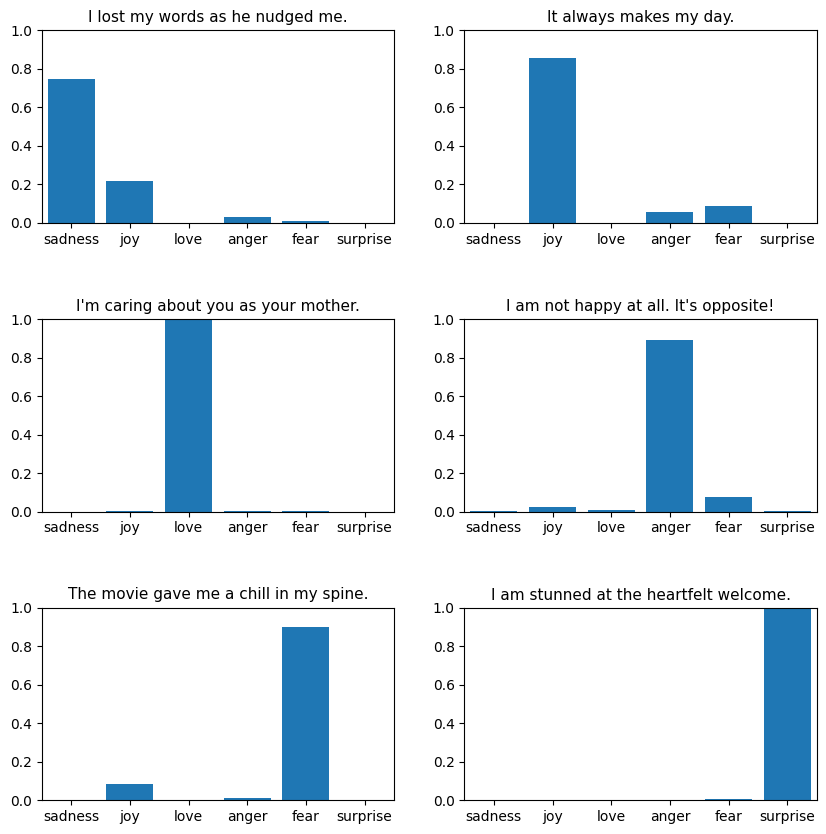

In [13]:
input_text = [
    "I lost my words as he nudged me.",
    "It always makes my day.",
    "I'm caring about you as your mother.",
    "I am not happy at all. It's opposite!",
    "The movie gave me a chill in my spine.",
    "I am stunned at the heartfelt welcome."
]

tokenized_text = tokenizer(input_text, max_length=MAX_LEN,
                           padding='max_length', truncation=True)
input_ids = np.array(tokenized_text['input_ids'])
mask = np.array(tokenized_text['attention_mask'])

predictions = transformer_model.predict([input_ids, mask], verbose=0)

n = len(predictions)
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)

for c, pred in enumerate(predictions):
    subplot = fig.add_subplot(3, 2, c+1)
    subplot.set_xticks(range(6))
    subplot.set_xlim([-0.5, 5.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(emotion_labels)
    subplot.set_title(input_text[c], fontsize=11)
    _ = subplot.bar(range(6), pred, align='center')

Show attention weights (maximum over multiple attention heads, and averaged over two transformer layers).

**一例として、テキスト `The movie gave me a chill in my spine.` を入力した際のウェイトを個別に表示します。**

下記のコードでは、1 層目の 4 個のアテンションヘッド、および、2 層目の 4 個のアテンションヘッドのウェイトを個別に表示しています。ここでは、図を見やすくするために、予測に用いられる `[CLS]` に対する影響を表すウェイトの値のみを表示しています。

全体として、fear（恐怖）の感情を表す `gave`、`chill`、`spine` のウェイトが大きくなっていますが、それぞれの単語について、ウェイトが大きくなる層やアテンションヘッドが異なることがわかります。


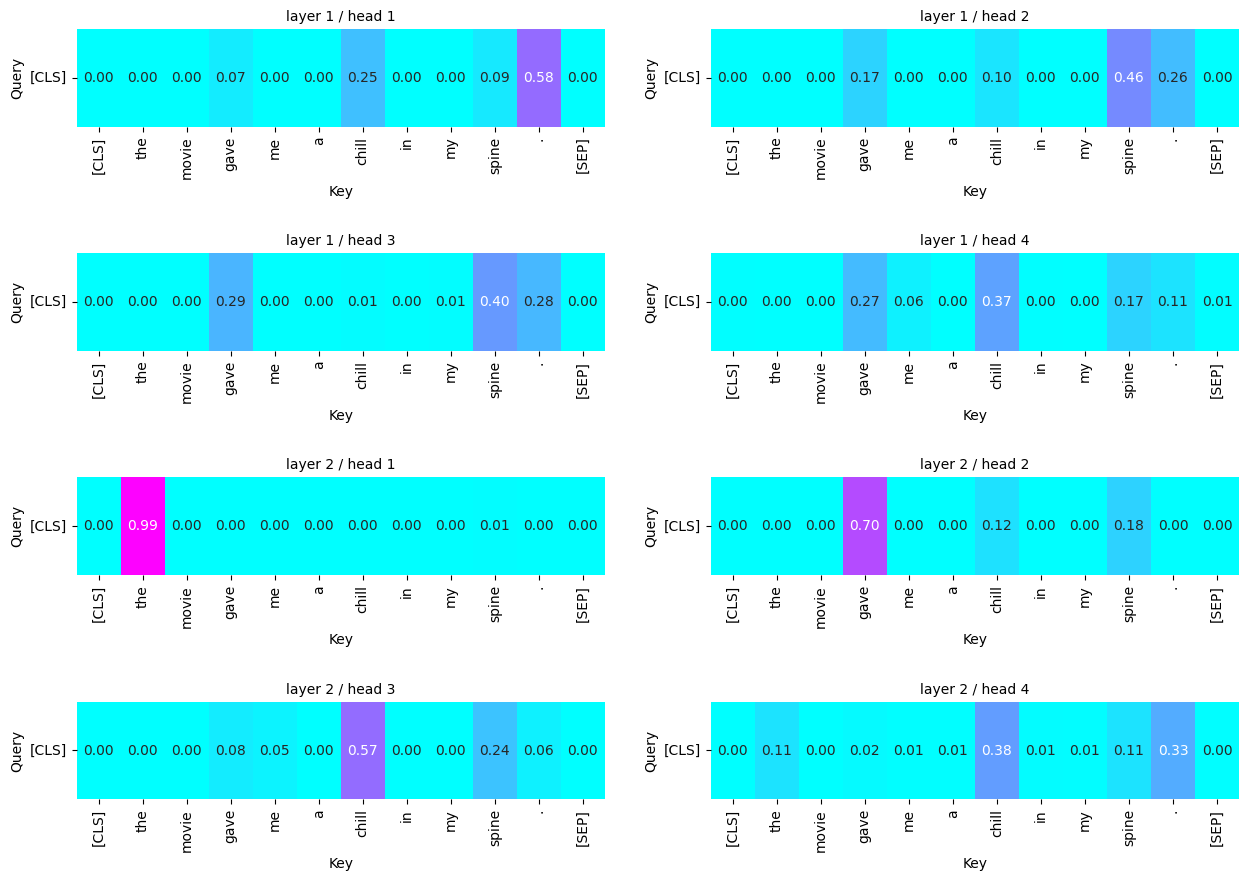

In [14]:
import seaborn as sns

pred, attention_scores1, attention_scores2 = attention_scores_model.predict(
    [input_ids, mask], verbose=0)

i = 4 # input_text[4] "The movie gave me a chill in my spine." について表示

labels = tokenizer.convert_ids_to_tokens(input_ids[i])
text_len = sum(mask[i])
scores1, scores2 = attention_scores1[i], attention_scores2[i]

fig = plt.figure(figsize=(text_len/2 * 2.5, N_HEADS//2 * 5))
fig.subplots_adjust(wspace=0.2, hspace=1.3)

# 1 層目の Query = [CLS] に対するウェイトを表示
for n in range(N_HEADS):
    scores = scores1[n, :1, :text_len]
    subplot = fig.add_subplot(N_HEADS, 2, n+1)
    heatmap = sns.heatmap(
        scores, ax=subplot, cmap='cool', vmin=0, vmax=1, cbar=False,
        annot=True, fmt='1.2f')
    heatmap.set_title(f'layer 1 / head {n+1}', fontsize=10)
    heatmap.set_xticklabels(labels[:text_len], rotation=90)
    heatmap.set_yticklabels(labels[:1], rotation=0)
    _ = heatmap.set(xlabel='Key', ylabel='Query')

# 2 層目の Query = [CLS] に対するウェイトを表示
for n in range(4):
    scores = scores2[n, :1, :text_len]
    subplot = fig.add_subplot(4, 2, n+5)
    heatmap = sns.heatmap(
        scores, ax=subplot, cmap='cool', vmin=0, vmax=1, cbar=False,
        annot=True, fmt='1.2f')
    heatmap.set_title(f'layer 2 / head {n+1}', fontsize=10)
    heatmap.set_xticklabels(labels[:text_len], rotation=90)
    heatmap.set_yticklabels(labels[:1], rotation=0)
    _ = heatmap.set(xlabel='Key', ylabel='Query')